In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim

# install nflows package as: $ pip install nflows
from nflows.flows.base import Flow
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform, MaskedPiecewiseQuadraticAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.nn.nets import ResidualNet

In [2]:
# Get calibration observations and labels 
# Load observations
# file = np.load('../Mixed_data/NF_mixed_train_test_data.npz')  # get earth data after earth_2_mars transform
# calib_data = file['y_calib']
# # Load wavelengths
# w = file['w']

# # Load compositions
# file2 = np.load('../calibration_data/calibration_data.npz')
# comp = file2['c']
# comp.shape

# # Plot first sample
# plt.plot(w, calib_data[0,:])
# plt.show()
# calib_data.shape

In [3]:
# Set up data

# LIBS data
# x = calib_data
# y = comp[:,0]
# x = torch.tensor(x, dtype=torch.float32)
# y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
# dim_in = x.shape[1]
# dim_out = 1


# moons data (toy 2D dataset)
x, y = datasets.make_moons(400, noise=.1)
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
dim_in = 2
dim_out = 1


#California housing dataset
# import sklearn
# housing = sklearn.datasets.fetch_california_housing()
# x = housing.data[:1000]
# y = housing.target[:1000]
# x = torch.tensor(x, dtype=torch.float32)
# y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
# dim_in = x.shape[1]
# dim_out = y.shape[1]

In [4]:
print(x.shape, y.shape)

torch.Size([400, 2]) torch.Size([400, 1])


In [5]:
num_layers = 5
base_dist = ConditionalDiagonalNormal(shape=[dim_in], 
                                      context_encoder=nn.Linear(1, 2*dim_in))

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=dim_in))
    transforms.append(MaskedAffineAutoregressiveTransform(features=dim_in, 
                                                          hidden_features=4, 
                                                          context_features=dim_out))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [6]:
num_iter = 2000
loss_all = []
for i in range(num_iter):
    
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x, context=y).mean()
    
    loss_all.append(loss.item())  # save loss
    if (i + 1) % 200 == 0:
        print('Loss:', loss.item())
    
    loss.backward()
    optimizer.step()


Loss: 1.8432120084762573
Loss: 1.4016685485839844
Loss: 1.1709017753601074
Loss: 0.7958227396011353
Loss: 0.5213993787765503
Loss: 0.39345768094062805
Loss: 0.3523269593715668
Loss: 0.33211711049079895
Loss: 0.32146763801574707
Loss: 0.31454411149024963


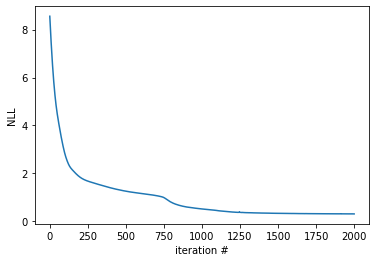

In [7]:
# Save results
plt.figure()
plt.plot(loss_all)
plt.xlabel('iteration #')
plt.ylabel('NLL')

import os
if not os.path.exists('results'):
    os.makedirs('results')
plt.savefig('results/loss.png')

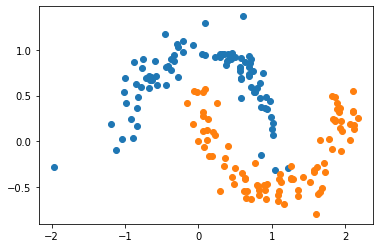

In [8]:
# Reconstruct moons from known labels
import numpy as np
bb = np.array([0,1]) # get samples from both labels (for regression problems this is not binary)
sav = flow.sample_and_log_prob(num_samples=90, context=torch.as_tensor(bb.reshape(-1,1)).float())
plt.scatter(sav[0][0][:,0].detach().numpy(), sav[0][0][:,1].detach().numpy())
plt.scatter(sav[0][1][:,0].detach().numpy(), sav[0][1][:,1].detach().numpy())